In [9]:
import numpy as np
import cupy as cp
from numba import jit, prange
import timeit
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix
from cupyx.scipy.sparse import coo_matrix as cp_coo_matrix

In [20]:
def sc_csr_base(data, row, col, n):
    mat = csr_matrix((data,(row, col)), shape=(n,n))
    
def sc_coo_base(data, row, col, n):
    mat = coo_matrix((data,(row, col)), shape=(n,n)).tocsr()
    
def sc_cp(data, row, col, n):
    cmat = cp_coo_matrix((data, (row, col)), shape=(n,n)).tocsr()
    
def npcopy_base(row, col, data):
    a=np.copy(row)
    b=np.copy(col)
    c=np.copy(data)
    
@jit(nopython=True)
def npcopy_nb(row, col, data):
    a=np.copy(row)
    b=np.copy(col)
    c=np.copy(data)
    
@jit(nopython=True, parallel=True)
def npcopy_nb_parallel(row, col, data):
    a = np.zeros(row.shape[0])
    for i in prange(row.shape[0]):
        a[i] = row[i]
    b = np.zeros(col.shape[0])
    for i in prange(col.shape[0]):
        b[i] = col[i]
    c = np.zeros(data.shape[0])
    for i in prange(data.shape[0]):
        c[i] = data[i]

In [21]:
n = 2965820
row, col = np.random.randint(0, n, (2, n))
data = np.random.rand(n)
# npcopy_nb_parallel(row, col, data)
# npcopy_nb_parallel.parallel_diagnostics(level=4)

In [22]:
%timeit npcopy_nb_parallel(row, col, data)

/home/alm818/.local/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-20-e9f5104aa633>", line 22:
@jit(nopython=True, parallel=True)
def npcopy_nb_parallel(row, col, data):
^

  state.func_ir.loc))


320 ns ± 3.96 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [3]:
N = [int(8*(2**0.5)**i) for i in range(38)]
print(N)

[8, 11, 16, 22, 32, 45, 64, 90, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2896, 4096, 5792, 8192, 11585, 16384, 23170, 32768, 46340, 65536, 92681, 131072, 185363, 262144, 370727, 524288, 741455, 1048576, 1482910, 2097152, 2965820]


In [4]:
SIZE = 50000
methods = ["sc_csr_base", "sc_coo_base", "sc_cp", "npcopy_base", "npcopy_nb", "npcopy_nb_parallel"]
K = len(methods)
funcs = [sc_csr_base, sc_coo_base, sc_cp, npcopy_base, npcopy_nb, npcopy_nb_parallel]
masks = [1, 1, 1, 1, 1, 1]
groups = [0, 0, 0, 1, 1, 1]
T = [[] for i in range(K)]
for n in N:
    print("Start with size:", n)
    row, col = np.random.randint(0, n, (2, n))
    data = np.random.rand(n)

    crow = cp.array(row)
    ccol = cp.array(col)
    cdata = cp.array(data)
    
    args = [(data, row, col, n), (data, row, col, n), (cdata, crow, ccol, n), (row, col, data), (row, col, data), (row, col, data)]
    
    for i in range(K):
        t = %timeit -q -n 1 -r 3 -o funcs[i](*args[i])
        T[i].append(t.average*1000)

Start with size: 8


/home/alm818/.local/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-2-e9f5104aa633>", line 22:
@jit(nopython=True, parallel=True)
def npcopy_nb_parallel(row, col, data):
^

  state.func_ir.loc))


Start with size: 11
Start with size: 16
Start with size: 22
Start with size: 32
Start with size: 45
Start with size: 64
Start with size: 90
Start with size: 128
Start with size: 181
Start with size: 256
Start with size: 362
Start with size: 512
Start with size: 724
Start with size: 1024
Start with size: 1448
Start with size: 2048
Start with size: 2896
Start with size: 4096
Start with size: 5792
Start with size: 8192
Start with size: 11585
Start with size: 16384
Start with size: 23170
Start with size: 32768
Start with size: 46340
Start with size: 65536
Start with size: 92681
Start with size: 131072
Start with size: 185363
Start with size: 262144
Start with size: 370727
Start with size: 524288
Start with size: 741455
Start with size: 1048576
Start with size: 1482910
Start with size: 2097152
Start with size: 2965820


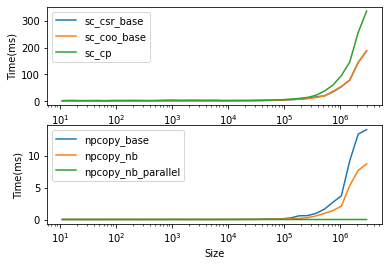

In [5]:
n_groups = max(groups)+1
fig, axs = plt.subplots(n_groups)
plt.rcParams["figure.figsize"] = (10,15)
if n_groups == 1:
    for i in range(K):
        if masks[i]:
            axs.plot(N[1:], T[i][1:], label=methods[i])
    axs.set_xlabel("Size")
    axs.set_ylabel("Time(ms)")
    axs.legend()
    axs.set_xscale('log')
else:
    for g in range(n_groups):
        for i in range(K):
            if masks[i] and groups[i] == g:
                axs[g].plot(N[1:], T[i][1:], label=methods[i])
        axs[g].set_xlabel("Size")
        axs[g].set_ylabel("Time(ms)")
        axs[g].legend()
        axs[g].set_xscale('log')
plt.show()

In [6]:
print(T)

[[0.22149233336676843, 0.190979666513158, 0.3516923334245803, 0.25426233332837, 0.17814566672313958, 0.20255766624662405, 0.19029433254521186, 0.17608666651843427, 0.23214133337508733, 0.20385600024989495, 0.20777866666321643, 0.20097633265928985, 0.26951666647316114, 0.23909833362267818, 0.3332129999762401, 0.2378423335661258, 0.2793273336768228, 0.32730033368958783, 0.33080166698103614, 0.3850773330971909, 0.4531083329008349, 0.5551486665353877, 0.7317990002775332, 0.9189563334075501, 1.2298849997023353, 1.7616803343116771, 2.3991383338094843, 3.2303353333797227, 4.569510000389225, 6.32750599955519, 9.269189999031369, 15.158685332911167, 19.04580933296529, 33.74341300028997, 53.168426333286334, 78.60597233290416, 144.46638733352302, 188.15736266636426], [0.11860199992952403, 0.11874433342503228, 0.13587099965661764, 0.125790000311099, 0.11960600022575818, 0.23847266675147694, 0.1215793339118439, 0.12502733322132067, 0.2260216660943115, 0.13013899964183415, 0.13155499982531182, 0.1555